# Stage 3: NLOS Ranging Error Prediction
## Multi-Model Pipeline — Correctable NLOS Distance Correction

**Purpose**: Given a **correctable** NLOS signal (filtered by Stage 2's mixture quality label), predict the **per-sample ranging error** — the difference between the DW1000's reported distance and the true direct distance.

**Why this matters**: In NLOS conditions, the UWB chip reports a distance that overshoots the true TX→RX distance. By predicting this error per sample, we can correct the measurement:
```
d_corrected = Distance_hardware - predicted_error
```

**Target**: Per-sample ranging error = `Distance - d_direct` (varies per sample)

**Filtering**: Only correctable NLOS samples (Stage 2 mixture label = 0):
- Bounce dominance ≥ threshold (geometric: energy concentrated at known bounce position)
- Peak count ≤ 2 (morphological: simple CIR morphology)

**Architecture**: Frozen DualCircuit_PI_HLNN encoder → 64-dim LNN embeddings → Random Forest Regressor

**Pipeline**: Stage 1 (LNN → LOS/NLOS) → Stage 2 (LNN embeddings → RF → signal quality) → **Stage 3 (LNN embeddings → RF → ranging error → corrected distance)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.signal import find_peaks
from scipy.stats import kurtosis as scipy_kurtosis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os

# ==========================================
# CONFIGURATION
# ==========================================
CONFIG = {
    # ROI alignment (same as Stage 1 & 2)
    "search_start": 740,
    "search_end": 890,
    # Peak detection — morphological (same as Stage 2)
    "peak_prominence": 0.20,
    "peak_min_distance": 5,
    "dominant_path_max_peaks": 2,
    # Geometric bounce dominance (same as Stage 2)
    "bounce_search_window": 3,
    "dominance_threshold": 0.50,
    # Random Forest Regressor
    "n_estimators": 200,
    "max_depth": None,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    # Split
    "test_ratio": 0.30,
    "seed": 42,
}

np.random.seed(CONFIG["seed"])
print(f"Config: {CONFIG}")
print(f"\nFilter: Stage 2 mixture (bounce dominance >= {CONFIG['dominance_threshold']:.0%} AND peaks <= {CONFIG['dominant_path_max_peaks']})")
print(f"Target: per-sample ranging error = Distance - d_direct")
print(f"Model input: 64-dim LNN embeddings (from frozen Stage 1 DualCircuit_PI_HLNN)")

Config: {'search_start': 740, 'search_end': 890, 'peak_prominence': 0.2, 'peak_min_distance': 5, 'dominant_path_max_peaks': 2, 'bounce_search_window': 3, 'dominance_threshold': 0.5, 'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'test_ratio': 0.3, 'seed': 42}

Filter: Stage 2 mixture (bounce dominance >= 50% AND peaks <= 2)
Target: per-sample ranging error = Distance - d_direct
Model input: 64-dim LNN embeddings (from frozen Stage 1 DualCircuit_PI_HLNN)


---
## Section 2: Data Loading, Correctable Filtering & Target Assignment

1. Load NLOS samples from the combined dataset
2. Apply **Stage 2 mixture filter** — keep only correctable samples:
   - Geometric: bounce dominance ≥ 0.50 (energy at `bounce_path_idx` / ROI energy)
   - Morphological: peak count ≤ 2 (simple CIR morphology)
3. Extract FP_AMPL1/2/3 for encoder conditioning
4. Target = `Distance - d_direct` (per-sample ranging error from CSV columns)

In [2]:
# ==========================================
# ROI ALIGNMENT (reused from Stage 1 & 2)
# ==========================================
def get_roi_alignment(sig, search_start=CONFIG["search_start"],
                      search_end=CONFIG["search_end"]):
    """Find leading edge by backtracking from peak."""
    region = sig[search_start:search_end]
    if len(region) == 0:
        return np.argmax(sig)
    peak_local = np.argmax(region)
    peak_idx = search_start + peak_local
    peak_val = sig[peak_idx]
    noise_section = sig[:search_start]
    if len(noise_section) > 10:
        noise_mean = np.mean(noise_section)
        noise_std = np.std(noise_section)
        threshold = max(noise_mean + 3 * noise_std, 0.05 * peak_val)
    else:
        threshold = 0.05 * peak_val
    leading_edge = peak_idx
    for i in range(peak_idx, max(search_start - 20, 0), -1):
        if sig[i] < threshold:
            leading_edge = i + 1
            break
    return leading_edge


# ==========================================
# COUNT PEAKS IN CIR ROI (morphological — same as Stage 2)
# ==========================================
def count_peaks(sig, leading_edge, config=CONFIG):
    """Count prominent peaks in CIR ROI (120 samples from leading edge)."""
    roi_start = max(0, leading_edge - 5)
    roi_end = min(len(sig), leading_edge + 120)
    roi = sig[roi_start:roi_end]
    if len(roi) == 0 or np.max(roi) == 0:
        return 0
    roi_norm = roi / np.max(roi)
    peaks, _ = find_peaks(
        roi_norm,
        prominence=config["peak_prominence"],
        distance=config["peak_min_distance"]
    )
    return len(peaks)


# ==========================================
# GEOMETRIC BOUNCE DOMINANCE (same as Stage 2)
# ==========================================
def compute_bounce_dominance(sig, leading_edge, bounce_path_idx,
                              window=CONFIG["bounce_search_window"]):
    """
    Fraction of ROI energy concentrated at the geometric bounce position.
    Uses bounce_path_idx (known from TX->reflector->RX floor-plan geometry).
    """
    roi_start = max(0, leading_edge - 5)
    roi_end = min(len(sig), leading_edge + 120)

    roi_energy = np.sum(sig[roi_start:roi_end] ** 2)
    if roi_energy < 1e-10:
        return 0.0

    bounce_idx = int(round(bounce_path_idx))
    b_start = max(roi_start, bounce_idx - window)
    b_end = min(roi_end, bounce_idx + window + 1)

    if b_start >= b_end:
        return 0.0

    bounce_energy = np.sum(sig[b_start:b_end] ** 2)
    return bounce_energy / roi_energy


def get_distance_group(source_file):
    """Extract distance group from source filename."""
    match = re.search(r'([\d.]+)m_nlos', str(source_file))
    return match.group(1) + 'm' if match else 'unknown'


# ==========================================
# LOAD CORRECTABLE NLOS DATA (Stage 2 mixture filter)
# ==========================================
def load_correctable_data(filepath="../dataset/channels/combined_uwb_dataset.csv"):
    """
    Load NLOS samples, apply Stage 2 mixture filter (correctable only),
    compute per-sample ranging error target.
    """
    print(f"Loading: {filepath}")
    df = pd.read_csv(filepath)
    nlos_df = df[df["Label"] == 1].reset_index(drop=True)
    print(f"  Total samples: {len(df)}, NLOS samples: {len(nlos_df)}")

    cir_cols = sorted(
        [c for c in df.columns if c.startswith('CIR')],
        key=lambda x: int(x.replace('CIR', ''))
    )

    raw_sigs = []
    leading_edges = []
    fp_features = []
    ranging_errors = []
    source_files = []
    distances_hw = []
    d_directs = []
    d_bounces = []

    skipped_peaks = 0
    skipped_dominance = 0

    for idx, row in nlos_df.iterrows():
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values

        # RXPACC normalization
        rxpacc_col = 'RXPACC' if 'RXPACC' in row.index else 'RX_PACC'
        rxpacc = float(row.get(rxpacc_col, 128.0))
        if rxpacc > 0:
            sig = sig / rxpacc

        le = get_roi_alignment(sig)

        # ── Mixture filter (same criteria as Stage 2) ──
        # Morphological: peak count
        n_peaks = count_peaks(sig, le)
        if n_peaks > CONFIG["dominant_path_max_peaks"]:
            skipped_peaks += 1
            continue

        # Geometric: bounce dominance
        bpi = float(row.get('bounce_path_idx', np.nan))
        if np.isnan(bpi):
            skipped_dominance += 1
            continue
        bounce_dom = compute_bounce_dominance(sig, le, bpi)
        if bounce_dom < CONFIG["dominance_threshold"]:
            skipped_dominance += 1
            continue

        # ── Passed both filters → correctable sample ──
        # FP_AMPL features (same normalization as Stage 1)
        f1 = float(row.get('FP_AMPL1', 0)) / max(rxpacc, 1) / 64.0
        f2 = float(row.get('FP_AMPL2', 0)) / max(rxpacc, 1) / 64.0
        f3 = float(row.get('FP_AMPL3', 0)) / max(rxpacc, 1) / 64.0

        # Per-sample ranging error (target)
        hw_dist = float(row['Distance'])
        d_direct = float(row['d_direct'])
        d_bounce = float(row['d_bounce'])
        error = hw_dist - d_direct

        raw_sigs.append(sig)
        leading_edges.append(le)
        fp_features.append([f1, f2, f3])
        ranging_errors.append(error)
        source_files.append(str(row['Source_File']))
        distances_hw.append(hw_dist)
        d_directs.append(d_direct)
        d_bounces.append(d_bounce)

    fp_array = np.array(fp_features, dtype=np.float32)
    errors_array = np.array(ranging_errors, dtype=np.float32)

    total_skipped = skipped_peaks + skipped_dominance
    print(f"\n  Mixture filter (Stage 2 criteria):")
    print(f"    Passed (correctable):        {len(raw_sigs)}")
    print(f"    Skipped — too many peaks:    {skipped_peaks}")
    print(f"    Skipped — low bounce dom.:   {skipped_dominance}")
    print(f"    Total skipped (challenging): {total_skipped}")
    print(f"  FP_AMPL shape: {fp_array.shape}")
    print(f"  Ranging error stats:")
    print(f"    Mean: {errors_array.mean():.3f}m, Std: {errors_array.std():.3f}m")
    print(f"    Min: {errors_array.min():.3f}m, Max: {errors_array.max():.3f}m")

    return {
        'raw_sigs': np.array(raw_sigs),
        'leading_edges': np.array(leading_edges),
        'fp_features': fp_array,
        'ranging_errors': errors_array,
        'source_files': np.array(source_files),
        'distances_hw': np.array(distances_hw),
        'd_directs': np.array(d_directs),
        'd_bounces': np.array(d_bounces),
    }


data = load_correctable_data()

Loading: ../dataset/channels/combined_uwb_dataset.csv
  Total samples: 3600, NLOS samples: 1800

  Mixture filter (Stage 2 criteria):
    Passed (correctable):        479
    Skipped — too many peaks:    949
    Skipped — low bounce dom.:   372
    Total skipped (challenging): 1321
  FP_AMPL shape: (479, 3)
  Ranging error stats:
    Mean: 3.295m, Std: 1.748m
    Min: 0.116m, Max: 6.044m


---
## Section 3: Target Analysis

Validate the ranging error distribution across distance groups.

C:\Users\preca\AppData\Local\Temp\ipykernel_32312\668363542.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(group_data, labels=unique_groups, patch_artist=True)


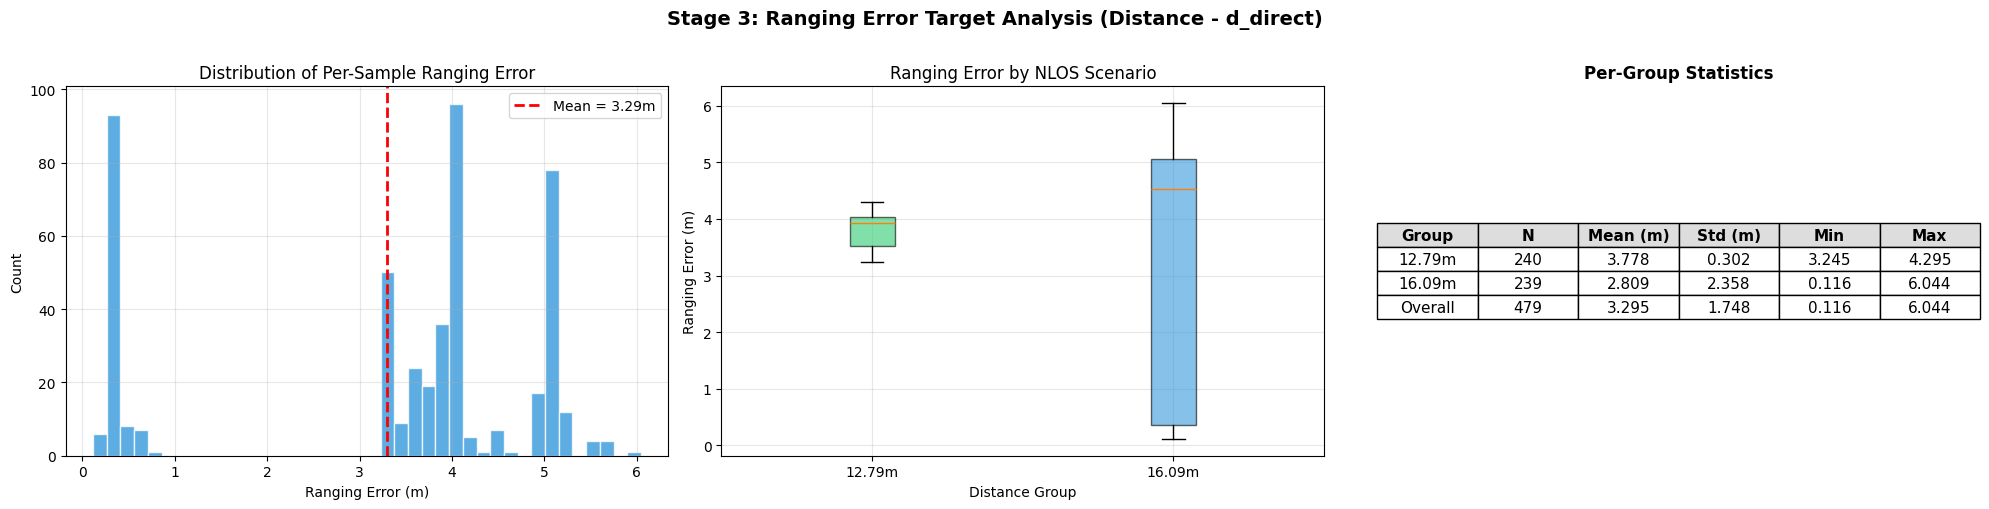

In [3]:
# ==========================================
# TARGET ANALYSIS
# ==========================================
errors = data['ranging_errors']
groups = np.array([get_distance_group(f) for f in data['source_files']])
unique_groups = sorted(set(groups))

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
plt.subplots_adjust(wspace=0.3)

# 1. Histogram of ranging errors
ax = axs[0]
ax.hist(errors, bins=40, color='#3498db', edgecolor='white', alpha=0.8)
ax.axvline(errors.mean(), color='red', ls='--', lw=2,
           label=f'Mean = {errors.mean():.2f}m')
ax.set_xlabel('Ranging Error (m)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Per-Sample Ranging Error')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Box plot by group
ax = axs[1]
group_data = [errors[groups == g] for g in unique_groups]
bp = ax.boxplot(group_data, labels=unique_groups, patch_artist=True)
colors_box = ['#2ecc71', '#3498db', '#e74c3c']
for patch, color in zip(bp['boxes'], colors_box[:len(unique_groups)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax.set_xlabel('Distance Group')
ax.set_ylabel('Ranging Error (m)')
ax.set_title('Ranging Error by NLOS Scenario')
ax.grid(True, alpha=0.3)

# 3. Per-group stats table
ax = axs[2]
ax.axis('off')
table_data = [['Group', 'N', 'Mean (m)', 'Std (m)', 'Min', 'Max']]
for g in unique_groups:
    mask = groups == g
    e = errors[mask]
    table_data.append([g, str(len(e)), f'{e.mean():.3f}',
                       f'{e.std():.3f}', f'{e.min():.3f}', f'{e.max():.3f}'])
table_data.append(['Overall', str(len(errors)), f'{errors.mean():.3f}',
                   f'{errors.std():.3f}', f'{errors.min():.3f}', f'{errors.max():.3f}'])
table = ax.table(cellText=table_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.0, 1.5)
# Bold header
for j in range(len(table_data[0])):
    table[0, j].set_text_props(fontweight='bold')
    table[0, j].set_facecolor('#ddd')
ax.set_title('Per-Group Statistics', fontsize=12, fontweight='bold')

plt.suptitle('Stage 3: Ranging Error Target Analysis (Distance - d_direct)',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---
## Section 4: Shared LNN Encoder — Embedding Extraction

Same frozen **DualCircuit_PI_HLNN** encoder as Stage 2. We extract **64-dim LNN embeddings** (attention-pooled hidden states from dual LOS/NLOS circuits) for each correctable NLOS sample.

FP_AMPL1/2/3 conditioning is passed to the encoder to produce the same embeddings as Stage 1 training.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class PILiquidCell(nn.Module):
    """
    Conductance-based LTC cell (Hasani et al. 2020).
    Hidden state clamped to [-1, 1] each sub-step.
    """
    def __init__(self, input_size, hidden_size, ode_unfolds=6):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.ode_unfolds = ode_unfolds

        self.gleak = nn.Parameter(torch.empty(hidden_size).uniform_(0.001, 1.0))
        self.vleak = nn.Parameter(torch.empty(hidden_size).uniform_(-0.2, 0.2))
        self.cm    = nn.Parameter(torch.empty(hidden_size).uniform_(0.4, 0.6))

        self.w     = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(0.001, 1.0))
        self.erev  = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(-0.2, 0.2))
        self.mu    = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(0.3, 0.8))
        self.sigma = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(3, 8))

        self.sensory_w     = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(0.001, 1.0))
        self.sensory_mu    = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(0.3, 0.8))
        self.sensory_sigma = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(3, 8))

    def forward(self, x_t, h_prev, dt=1.0):
        gleak     = F.softplus(self.gleak)
        cm        = F.softplus(self.cm)
        w         = F.softplus(self.w)
        sensory_w = F.softplus(self.sensory_w)

        sensory_gate    = torch.sigmoid(self.sensory_sigma * (x_t.unsqueeze(-1) - self.sensory_mu))
        sensory_current = (sensory_w * sensory_gate * x_t.unsqueeze(-1)).sum(dim=1)

        cm_t = cm / (dt / self.ode_unfolds)
        v    = h_prev

        for _ in range(self.ode_unfolds):
            recurrent_gate = torch.sigmoid(self.sigma.unsqueeze(0) * (v.unsqueeze(2) - self.mu.unsqueeze(0)))
            w_gate = w.unsqueeze(0) * recurrent_gate
            w_num  = (w_gate * self.erev.unsqueeze(0)).sum(dim=1)
            w_den  = w_gate.sum(dim=1)
            numerator   = cm_t * v + gleak * self.vleak + w_num + sensory_current
            denominator = cm_t + gleak + w_den + 1e-8
            v = numerator / denominator
            v = torch.clamp(v, -1.0, 1.0)

        tau = cm / (gleak + w_den + 1e-8)
        return v, tau


class DualCircuit_PI_HLNN(nn.Module):
    """
    Dual-circuit PI-HLNN with cross-circuit communication + FP_AMPL conditioning.
    Must match Stage 1 architecture exactly for weight loading.
    """
    def __init__(self, input_size=1, hidden_size=32, dropout=0.4, ode_unfolds=6):
        super().__init__()
        self.hidden_size = hidden_size

        self.cell_los  = PILiquidCell(input_size, hidden_size, ode_unfolds)
        self.cell_nlos = PILiquidCell(input_size, hidden_size, ode_unfolds)

        self.fp_to_los_init  = nn.Linear(3, hidden_size)
        self.fp_to_nlos_init = nn.Linear(3, hidden_size)

        self.P_nlos2los = nn.Linear(hidden_size, hidden_size, bias=False)
        self.P_los2nlos = nn.Linear(hidden_size, hidden_size, bias=False)

        self.gate_los  = nn.Linear(hidden_size * 2, hidden_size)
        self.gate_nlos = nn.Linear(hidden_size * 2, hidden_size)

        self.los_attn  = nn.Linear(hidden_size, 1)
        self.nlos_attn = nn.Linear(hidden_size, 1)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def _run_circuits(self, x_seq, fp_features=None):
        batch_size, seq_len, _ = x_seq.size()
        if fp_features is not None:
            h_los  = 0.1 * torch.tanh(self.fp_to_los_init(fp_features))
            h_nlos = 0.1 * torch.tanh(self.fp_to_nlos_init(fp_features))
        else:
            h_los  = torch.zeros(batch_size, self.hidden_size, device=x_seq.device)
            h_nlos = torch.zeros(batch_size, self.hidden_size, device=x_seq.device)

        los_states, nlos_states = [], []
        tau_los_sum  = torch.zeros_like(h_los)
        tau_nlos_sum = torch.zeros_like(h_nlos)
        tau_los_hist_list, tau_nlos_hist_list = [], []

        for t in range(seq_len):
            x_t = x_seq[:, t, :]
            proj_nlos_to_los = self.P_nlos2los(h_nlos)
            proj_los_to_nlos = self.P_los2nlos(h_los)
            g_los  = torch.sigmoid(self.gate_los( torch.cat([h_los,  proj_nlos_to_los], dim=1)))
            g_nlos = torch.sigmoid(self.gate_nlos(torch.cat([h_nlos, proj_los_to_nlos], dim=1)))
            h_los_in  = h_los  + g_los  * proj_nlos_to_los
            h_nlos_in = h_nlos + g_nlos * proj_los_to_nlos
            h_los,  tau_los  = self.cell_los( x_t, h_los_in)
            h_nlos, tau_nlos = self.cell_nlos(x_t, h_nlos_in)
            los_states.append(h_los.unsqueeze(1))
            nlos_states.append(h_nlos.unsqueeze(1))
            tau_los_sum  += tau_los
            tau_nlos_sum += tau_nlos
            tau_los_hist_list.append(tau_los.unsqueeze(1))
            tau_nlos_hist_list.append(tau_nlos.unsqueeze(1))

        los_all  = torch.cat(los_states,  dim=1)
        nlos_all = torch.cat(nlos_states, dim=1)
        tau_los_mean  = tau_los_sum  / seq_len
        tau_nlos_mean = tau_nlos_sum / seq_len
        tau_los_hist  = torch.cat(tau_los_hist_list,  dim=1)
        tau_nlos_hist = torch.cat(tau_nlos_hist_list, dim=1)
        return los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean

    def _pool_and_fuse(self, los_all, nlos_all):
        los_w  = F.softmax(self.los_attn(los_all).squeeze(-1),   dim=1).unsqueeze(-1)
        nlos_w = F.softmax(self.nlos_attn(nlos_all).squeeze(-1), dim=1).unsqueeze(-1)
        h_los_pooled  = (los_all  * los_w).sum(dim=1)
        h_nlos_pooled = (nlos_all * nlos_w).sum(dim=1)
        return torch.cat([h_los_pooled, h_nlos_pooled], dim=1)

    def forward(self, x_seq, fp_features=None, return_dynamics=False):
        los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean = \
            self._run_circuits(x_seq, fp_features=fp_features)
        h_fused = self._pool_and_fuse(los_all, nlos_all)
        pred = self.classifier(h_fused)
        if return_dynamics:
            return pred, los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean
        return pred, tau_los_mean, tau_nlos_mean

    def embed(self, x_seq, fp_features=None):
        """Return 64-dim fused embedding for Stage 2/3."""
        los_all, nlos_all, _, _, _, _ = self._run_circuits(x_seq, fp_features=fp_features)
        return self._pool_and_fuse(los_all, nlos_all)


print(f"DualCircuit_PI_HLNN defined: {sum(p.numel() for p in DualCircuit_PI_HLNN().parameters()):,} params")

DualCircuit_PI_HLNN defined: 17,219 params


In [5]:
# ==========================================
# LOAD FROZEN STAGE 1 ENCODER & EXTRACT EMBEDDINGS
# ==========================================
STAGE1_CONFIG = {
    'pre_crop': 10, 'post_crop': 50, 'total_len': 60,
    'search_start': 740, 'search_end': 890,
    'hidden_size': 32, 'input_size': 1, 'dropout': 0.2, 'ode_unfolds': 6,
}

EMBEDDING_DIM = STAGE1_CONFIG['hidden_size'] * 2  # 64 (2 circuits x 32)
EMBEDDING_NAMES = [f'LNN_h{i}' for i in range(EMBEDDING_DIM)]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def preprocess_cir_for_lnn(sig, leading_edge):
    """Convert a single RXPACC-normalized CIR + leading edge to 60-sample window."""
    PRE = STAGE1_CONFIG['pre_crop']
    TOTAL = STAGE1_CONFIG['total_len']
    start = max(0, leading_edge - PRE)
    end = start + TOTAL
    if end > len(sig):
        end = len(sig)
        start = max(0, end - TOTAL)
    crop = sig[start:end]
    if len(crop) < TOTAL:
        crop = np.pad(crop, (0, TOTAL - len(crop)), mode='constant')
    local_min, local_max = np.min(crop), np.max(crop)
    rng = local_max - local_min
    crop = (crop - local_min) / rng if rng > 0 else np.zeros(TOTAL)
    return crop


# Load frozen Stage 1 encoder
lnn_encoder = DualCircuit_PI_HLNN(
    input_size=STAGE1_CONFIG['input_size'],
    hidden_size=STAGE1_CONFIG['hidden_size'],
    dropout=STAGE1_CONFIG['dropout'],
    ode_unfolds=STAGE1_CONFIG['ode_unfolds'],
).to(device)

checkpoint_path = 'stage1_pi_hlnn_best.pt'
lnn_encoder.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
lnn_encoder.eval()
for param in lnn_encoder.parameters():
    param.requires_grad = False

print(f"Loaded frozen Stage 1 encoder from {checkpoint_path}")
print(f"  Architecture: DualCircuit_PI_HLNN (hidden={STAGE1_CONFIG['hidden_size']} per circuit)")
print(f"  Device: {device}")
print(f"  Parameters: {sum(p.numel() for p in lnn_encoder.parameters()):,} (all frozen)")
print(f"  Embedding dim: {EMBEDDING_DIM}")

# Extract 64-dim embeddings for all single-bounce NLOS samples
print(f"\nExtracting {EMBEDDING_DIM}-dim embeddings for {len(data['raw_sigs'])} samples...")

cir_sequences = []
for i in range(len(data['raw_sigs'])):
    crop = preprocess_cir_for_lnn(data['raw_sigs'][i], data['leading_edges'][i])
    cir_sequences.append(crop)

cir_tensor = torch.tensor(
    np.array(cir_sequences).reshape(-1, STAGE1_CONFIG['total_len'], 1),
    dtype=torch.float32
).to(device)

fp_tensor = torch.tensor(data['fp_features'], dtype=torch.float32).to(device)

all_embeddings = []
with torch.no_grad():
    for i in range(0, len(cir_tensor), 256):
        batch_cir = cir_tensor[i:i+256]
        batch_fp  = fp_tensor[i:i+256]
        emb = lnn_encoder.embed(batch_cir, fp_features=batch_fp)
        all_embeddings.append(emb.cpu().numpy())

embeddings = np.vstack(all_embeddings)

print(f"  Embeddings shape: {embeddings.shape}")
print(f"  Embedding stats — mean: {embeddings.mean():.4f}, std: {embeddings.std():.4f}")
print(f"\nReady for Random Forest training.")

Loaded frozen Stage 1 encoder from stage1_pi_hlnn_best.pt
  Architecture: DualCircuit_PI_HLNN (hidden=32 per circuit)
  Device: cuda
  Parameters: 17,219 (all frozen)
  Embedding dim: 64

Extracting 64-dim embeddings for 479 samples...
  Embeddings shape: (479, 64)
  Embedding stats — mean: 0.0574, std: 0.0924

Ready for Random Forest training.


---
## Section 5: Random Forest Regressor on LNN Embeddings

**Architecture**: Frozen DualCircuit_PI_HLNN encoder → 64-dim LNN embeddings → Random Forest Regressor

**Target**: Per-sample ranging error = `Distance - d_direct` (in meters)

**Data**: Only correctable NLOS samples (passed Stage 2 mixture filter — high bounce dominance AND simple morphology). These are the samples where ranging error correction is most reliable.

**Why Random Forest for regression:**
- Handles 64-dim tabular features natively
- Small dataset (~correctable samples) — RF works well without overfitting
- Built-in feature importance shows which embedding dimensions drive error prediction
- No hyperparameter tuning needed for learning rate/epochs

In [6]:
# ==========================================
# RANDOM FOREST TRAINING ON LNN EMBEDDINGS (70/30 SPLIT)
# ==========================================
X_all = embeddings
y_all = data['ranging_errors']
groups_all = np.array([get_distance_group(f) for f in data['source_files']])

# 70/30 stratified split (stratify by distance group)
X_train, X_test, y_train, y_test, grp_train, grp_test, \
    dist_hw_train, dist_hw_test, d_direct_train, d_direct_test = train_test_split(
    X_all, y_all, groups_all,
    data['distances_hw'], data['d_directs'],
    test_size=CONFIG["test_ratio"],
    stratify=groups_all,
    random_state=CONFIG["seed"]
)

print(f"Input: {EMBEDDING_DIM}-dim LNN embeddings (from frozen DualCircuit_PI_HLNN)")
print(f"Target: per-sample ranging error (Distance - d_direct)")
print(f"\nSplit (70/30):")
print(f"  Train: {len(X_train)} samples")
print(f"  Test:  {len(X_test)} samples")
for g in sorted(set(grp_train)):
    n_tr = (grp_train == g).sum()
    n_te = (grp_test == g).sum()
    print(f"    {g}: train={n_tr}, test={n_te}")

# Train Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=CONFIG["n_estimators"],
    max_depth=CONFIG["max_depth"],
    min_samples_split=CONFIG["min_samples_split"],
    min_samples_leaf=CONFIG["min_samples_leaf"],
    random_state=CONFIG["seed"],
    n_jobs=-1,
)
rf_model.fit(X_train, y_train)

# Evaluate
train_pred = rf_model.predict(X_train)
test_pred = rf_model.predict(X_test)

train_mae = mean_absolute_error(y_train, train_pred)
test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)

print(f"\nResults:")
print(f"  Train MAE:  {train_mae:.4f}m")
print(f"  Test MAE:   {test_mae:.4f}m")
print(f"  Test RMSE:  {test_rmse:.4f}m")
print(f"  Test R²:    {test_r2:.4f}")

# Per-group test MAE
print(f"\nPer-group test MAE:")
for g in sorted(set(grp_test)):
    mask = grp_test == g
    g_mae = mean_absolute_error(y_test[mask], test_pred[mask])
    print(f"  {g}: MAE = {g_mae:.4f}m (n={mask.sum()})")

Input: 64-dim LNN embeddings (from frozen DualCircuit_PI_HLNN)
Target: per-sample ranging error (Distance - d_direct)

Split (70/30):
  Train: 335 samples
  Test:  144 samples
    12.79m: train=168, test=72
    16.09m: train=167, test=72

Results:
  Train MAE:  0.2571m
  Test MAE:   0.4492m
  Test RMSE:  0.8751m
  Test R²:    0.6961

Per-group test MAE:
  12.79m: MAE = 0.3315m (n=72)
  16.09m: MAE = 0.5668m (n=72)


---
## Section 6: Diagnostics

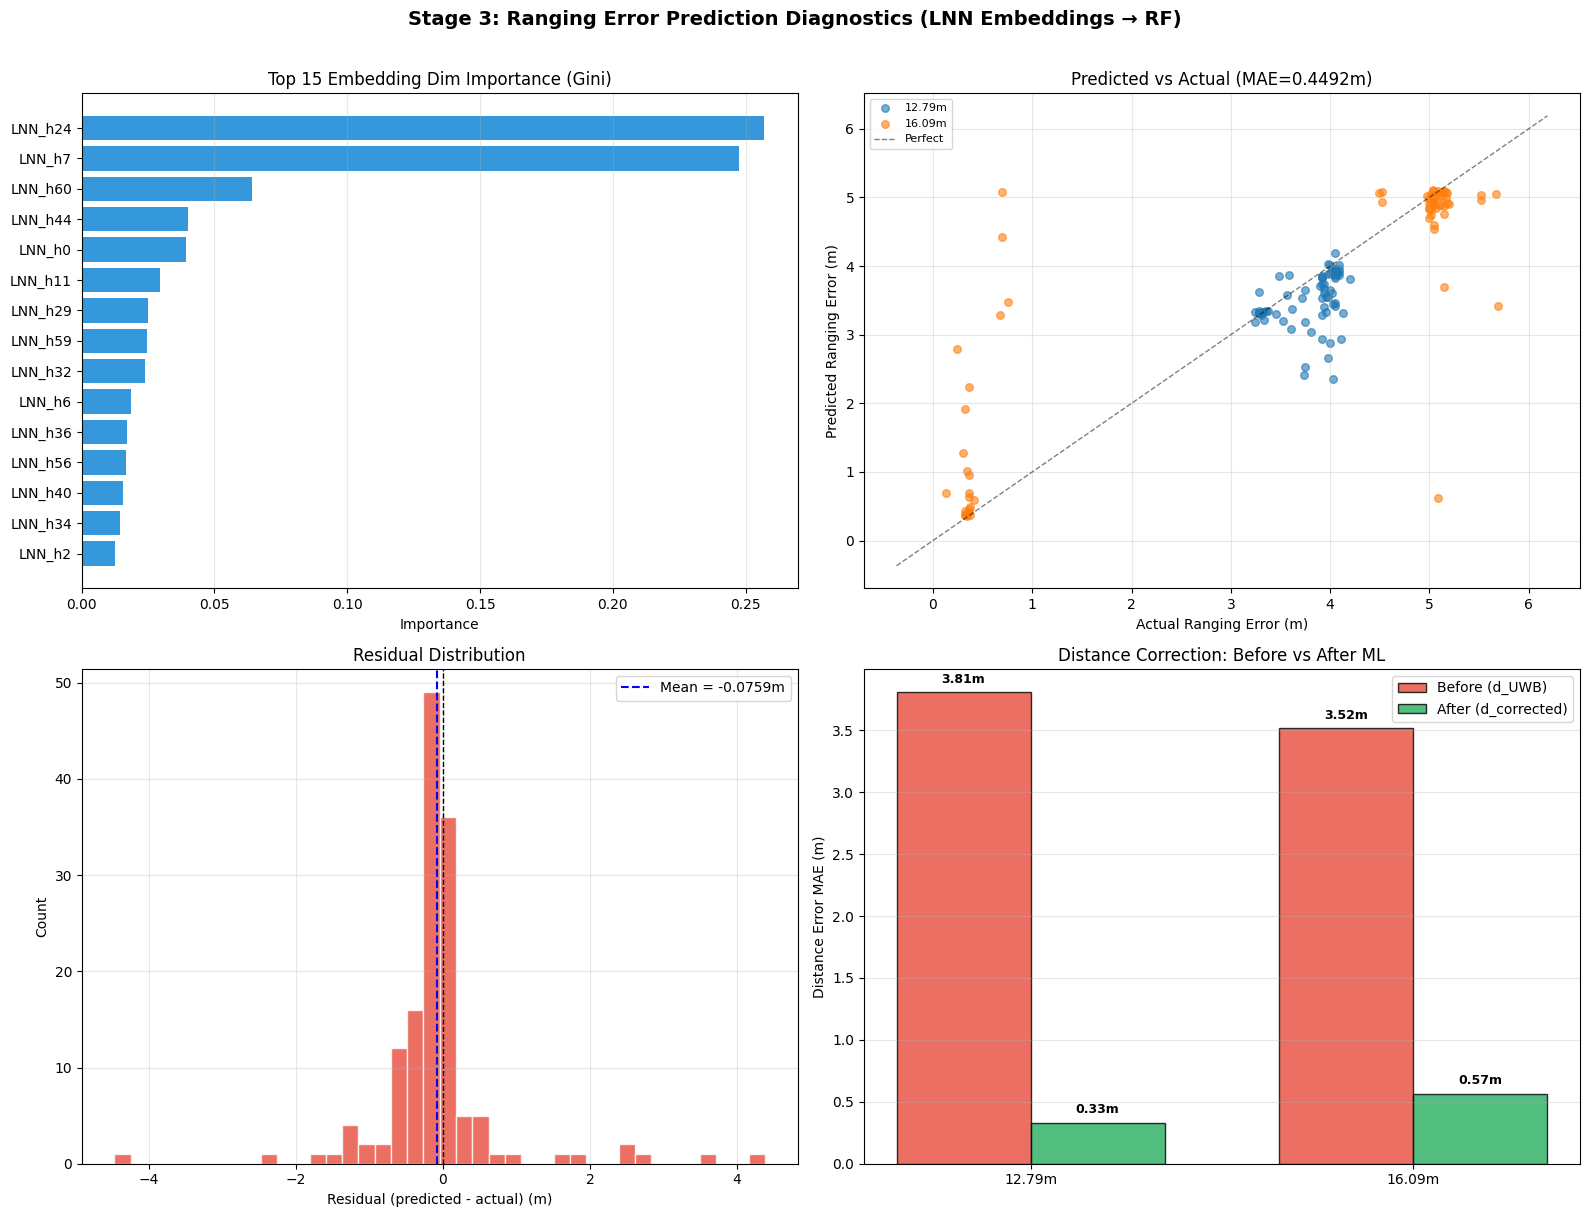


Distance Correction Summary (test set):
  Before ML: MAE = 3.6620m
  After ML:  MAE = 0.4492m
  Improvement: 8.2x lower error


In [7]:
# ==========================================
# DIAGNOSTICS
# ==========================================
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.35, wspace=0.3)

# 1. Feature Importance (top 15 embedding dimensions)
ax = axs[0, 0]
importances = rf_model.feature_importances_
top_k = min(15, len(importances))
sorted_idx = np.argsort(importances)[-top_k:]
ax.barh(np.array(EMBEDDING_NAMES)[sorted_idx], importances[sorted_idx], color='#3498db')
ax.set_title(f"Top {top_k} Embedding Dim Importance (Gini)")
ax.set_xlabel("Importance")
ax.grid(True, alpha=0.3, axis='x')

# 2. Predicted vs Actual
ax = axs[0, 1]
for g in sorted(set(grp_test)):
    mask = grp_test == g
    ax.scatter(y_test[mask], test_pred[mask], s=30, alpha=0.6, label=g)
lims = [min(y_test.min(), test_pred.min()) - 0.5,
        max(y_test.max(), test_pred.max()) + 0.5]
ax.plot(lims, lims, 'k--', lw=1, alpha=0.5, label='Perfect')
ax.set_xlabel('Actual Ranging Error (m)')
ax.set_ylabel('Predicted Ranging Error (m)')
ax.set_title(f'Predicted vs Actual (MAE={test_mae:.4f}m)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 3. Residuals histogram
ax = axs[1, 0]
residuals = test_pred - y_test
ax.hist(residuals, bins=40, color='#e74c3c', edgecolor='white', alpha=0.8)
ax.axvline(0, color='black', ls='--', lw=1)
ax.axvline(residuals.mean(), color='blue', ls='--', lw=1.5,
           label=f'Mean = {residuals.mean():.4f}m')
ax.set_xlabel('Residual (predicted - actual) (m)')
ax.set_ylabel('Count')
ax.set_title('Residual Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Distance correction result per group
ax = axs[1, 1]
d_corrected = dist_hw_test - test_pred
correction_errors = np.abs(d_corrected - d_direct_test)
original_errors = np.abs(dist_hw_test - d_direct_test)

group_names = sorted(set(grp_test))
x_pos = np.arange(len(group_names))
width = 0.35

orig_maes = [np.mean(original_errors[grp_test == g]) for g in group_names]
corr_maes = [np.mean(correction_errors[grp_test == g]) for g in group_names]

bars1 = ax.bar(x_pos - width/2, orig_maes, width, label='Before (d_UWB)',
               color='#e74c3c', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x_pos + width/2, corr_maes, width, label='After (d_corrected)',
               color='#27ae60', alpha=0.8, edgecolor='black')
for bar, val in zip(bars1, orig_maes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'{val:.2f}m', ha='center', va='bottom', fontsize=9, fontweight='bold')
for bar, val in zip(bars2, corr_maes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'{val:.2f}m', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(group_names)
ax.set_ylabel('Distance Error MAE (m)')
ax.set_title('Distance Correction: Before vs After ML')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Stage 3: Ranging Error Prediction Diagnostics (LNN Embeddings → RF)',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# Summary stats
print(f"\nDistance Correction Summary (test set):")
print(f"  Before ML: MAE = {np.mean(original_errors):.4f}m")
print(f"  After ML:  MAE = {np.mean(correction_errors):.4f}m")
print(f"  Improvement: {np.mean(original_errors)/np.mean(correction_errors):.1f}x lower error")

---
## Section 8: Save Artifacts

In [8]:
# ==========================================
# SAVE ARTIFACTS
# ==========================================
joblib.dump(rf_model, "stage3_nlos_bias_rf.joblib")
print("Saved: stage3_nlos_bias_rf.joblib")

joblib.dump({
    "config": CONFIG,
    "embedding_dim": EMBEDDING_DIM,
    "embedding_names": EMBEDDING_NAMES,
    "stage1_config": STAGE1_CONFIG,
    "encoder_class": "DualCircuit_PI_HLNN",
    "fp_conditioning": True,
    "target": "per-sample ranging error (Distance - d_direct)",
    "filter_strategy": "mixture_geometric_morphological",
    "dominance_threshold": CONFIG["dominance_threshold"],
    "bounce_search_window": CONFIG["bounce_search_window"],
    "dominant_path_max_peaks": CONFIG["dominant_path_max_peaks"],
    "note": "Model input is 64-dim LNN embeddings from frozen Stage 1 DualCircuit_PI_HLNN. "
            "Only correctable NLOS samples (Stage 2 mixture filter: high bounce dominance AND few peaks).",
}, "stage3_config.joblib")
print("Saved: stage3_config.joblib")

print(f"\nDependency: stage1_pi_hlnn_best.pt (frozen DualCircuit_PI_HLNN encoder)")
print(f"Pipeline complete.")

Saved: stage3_nlos_bias_rf.joblib
Saved: stage3_config.joblib

Dependency: stage1_pi_hlnn_best.pt (frozen DualCircuit_PI_HLNN encoder)
Pipeline complete.


In [9]:
print("=" * 60)
print("Stage 3 — Summary")
print("=" * 60)
print(f"Model artifact: stage3_nlos_bias_rf.joblib")
print(f"Config artifact: stage3_config.joblib")
print(f"Encoder dependency: stage1_pi_hlnn_best.pt (frozen DualCircuit_PI_HLNN)")
print()
print(f"Architecture: Frozen DualCircuit_PI_HLNN encoder → {EMBEDDING_DIM}-dim LNN embeddings → RF regressor")
print(f"FP_AMPL conditioning: enabled (FP_AMPL1/2/3 seed circuit initial states)")
print(f"Filter: Stage 2 mixture (bounce dominance >= {CONFIG['dominance_threshold']:.0%} AND peaks <= {CONFIG['dominant_path_max_peaks']})")
print(f"Target: per-sample ranging error (Distance - d_direct)")
print(f"Test MAE: {test_mae:.4f}m")
print()
print("Full Pipeline:")
print("  Stage 1: Raw CIR + FP_AMPL → DualCircuit_PI_HLNN → LOS/NLOS")
print("  Stage 2: NLOS LNN embeddings → RF → Signal quality (Correctable/Challenging)")
print("  Stage 3: Correctable LNN embeddings → RF → Ranging error")
print()
print("Inference:")
print("  d_corrected = Distance_hardware - predicted_error")

Stage 3 — Summary
Model artifact: stage3_nlos_bias_rf.joblib
Config artifact: stage3_config.joblib
Encoder dependency: stage1_pi_hlnn_best.pt (frozen DualCircuit_PI_HLNN)

Architecture: Frozen DualCircuit_PI_HLNN encoder → 64-dim LNN embeddings → RF regressor
FP_AMPL conditioning: enabled (FP_AMPL1/2/3 seed circuit initial states)
Filter: Stage 2 mixture (bounce dominance >= 50% AND peaks <= 2)
Target: per-sample ranging error (Distance - d_direct)
Test MAE: 0.4492m

Full Pipeline:
  Stage 1: Raw CIR + FP_AMPL → DualCircuit_PI_HLNN → LOS/NLOS
  Stage 2: NLOS LNN embeddings → RF → Signal quality (Correctable/Challenging)
  Stage 3: Correctable LNN embeddings → RF → Ranging error

Inference:
  d_corrected = Distance_hardware - predicted_error
